# CNN pretrained ResNet50 model 

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

## Content from Notebook 1

#### Pretrained ResNet50 CNN:

* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images

* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

---

## Content from Notebook 2

#### Pretrained ResNet50 CNN:

* Tests have shown that adding a dropout layer to the architecture, batch size of 16 as well as regularization increased the models performance. This is included in this model as well as setting model checkpoints.
* Thoughts on model checkpoints:
  * model.evaluate() in Keras uses the weights of the model at the time the method is called. So if you train a model for 20 epochs and call model.evaluate() immediately after training without making any further changes to the weights, then it will use the weights from the last, 20th epoch.
  * However, if you use a ModelCheckpoint with save_best_only=True during training, then the model's weights will only be saved if a particular metric (such as validation accuracy) improves. If you load these best weights into your model after training and then call model.evaluate(), the weights of the epoch with the best results will be used.
  * In summary, model.evaluate() always uses the current weights of the model. It is up to you to determine which weights are loaded in the model at which point in time. This is why we should use ModelCheckpoint with save_best_only=True to evaluate the *best* model.
* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images
* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and loading Data

## Content from Notebook 1

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

from time import sleep 

import cv2
import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 226
NUM_EPOCHS = 25

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 16

---

## Content from Notebook 2

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import math

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam as Adam_legacy
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.utils import class_weight


sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 226
NUM_EPOCHS = 20

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"
FILEPATH_MODELS = "../models/"

MODEL_NAME = 'Resnet50_tertiary_new_setup' # please adapt according to your changes using _ and - instead of " "

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 16 # Adapted according to findings

### Loading (augmented) metadata as test, train, validation from files

In [17]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,dx_tertiary,image_path
4821,HAM_0004371,aug_wRsyOoISIC_0027626.jpg,df,histo,45.0,female,upper extremity,rosendahl,not_skin_cancer,non-neoplastic,./../data/jpgs/aug_wRsyOoISIC_0027626.jpg
5101,HAM_0004103,aug_T0eUufISIC_0031309.jpg,df,histo,55.0,male,lower extremity,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/aug_T0eUufISIC_0031309.jpg
1437,HAM_0003007,ISIC_0025388.jpg,bkl,histo,40.0,female,abdomen,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0025388.jpg
2382,HAM_0000241,ISIC_0030932.jpg,mel,histo,70.0,female,lower extremity,rosendahl,skin_cancer,malignant,./../data/jpgs/ISIC_0030932.jpg
3825,HAM_0000109,ISIC_0031065.jpg,vasc,consensus,35.0,female,trunk,vidir_molemax,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0031065.jpg
3233,HAM_0001301,ISIC_0032307.jpg,bcc,histo,80.0,male,face,rosendahl,skin_cancer,malignant,./../data/jpgs/ISIC_0032307.jpg
2799,HAM_0000536,ISIC_0027359.jpg,mel,histo,45.0,female,lower extremity,rosendahl,skin_cancer,malignant,./../data/jpgs/ISIC_0027359.jpg
452,HAM_0003848,ISIC_0032096.jpg,nv,histo,55.0,female,abdomen,vidir_modern,not_skin_cancer,benign,./../data/jpgs/ISIC_0032096.jpg
2106,HAM_0005027,aug_cvLRoWISIC_0026138.jpg,akiec,histo,85.0,female,back,rosendahl,skin_cancer,malignant,./../data/jpgs/aug_cvLRoWISIC_0026138.jpg
4581,HAM_0005663,ISIC_0026417.jpg,df,consensus,30.0,male,lower extremity,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0026417.jpg


## Setting up the image data generator for training and validation

#### Function for custom preprocessing of the images

In [18]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

#### Data Image generator for Train and Validation

In [19]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    zoom_range=0.2,              # Randomly zoom in and out by up to 20%
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20%
    rotation_range=30,           # Randomly rotate images by up to 30 degrees
    shear_range=0.2,             # Shear intensity (shear angle in radians)
    fill_mode='nearest'          # Strategy for filling in newly created pixels after transformations
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    #save_to_dir=FILEPATH_OUTPUT,
    #save_prefix="test_gen_",
    #save_format="jpg",
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 5254 validated image filenames belonging to 3 classes.
Found 1001 validated image filenames belonging to 3 classes.


### Control: Show some images from the train data set after preprocessing

In [20]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [21]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

0.0 1.0 float32


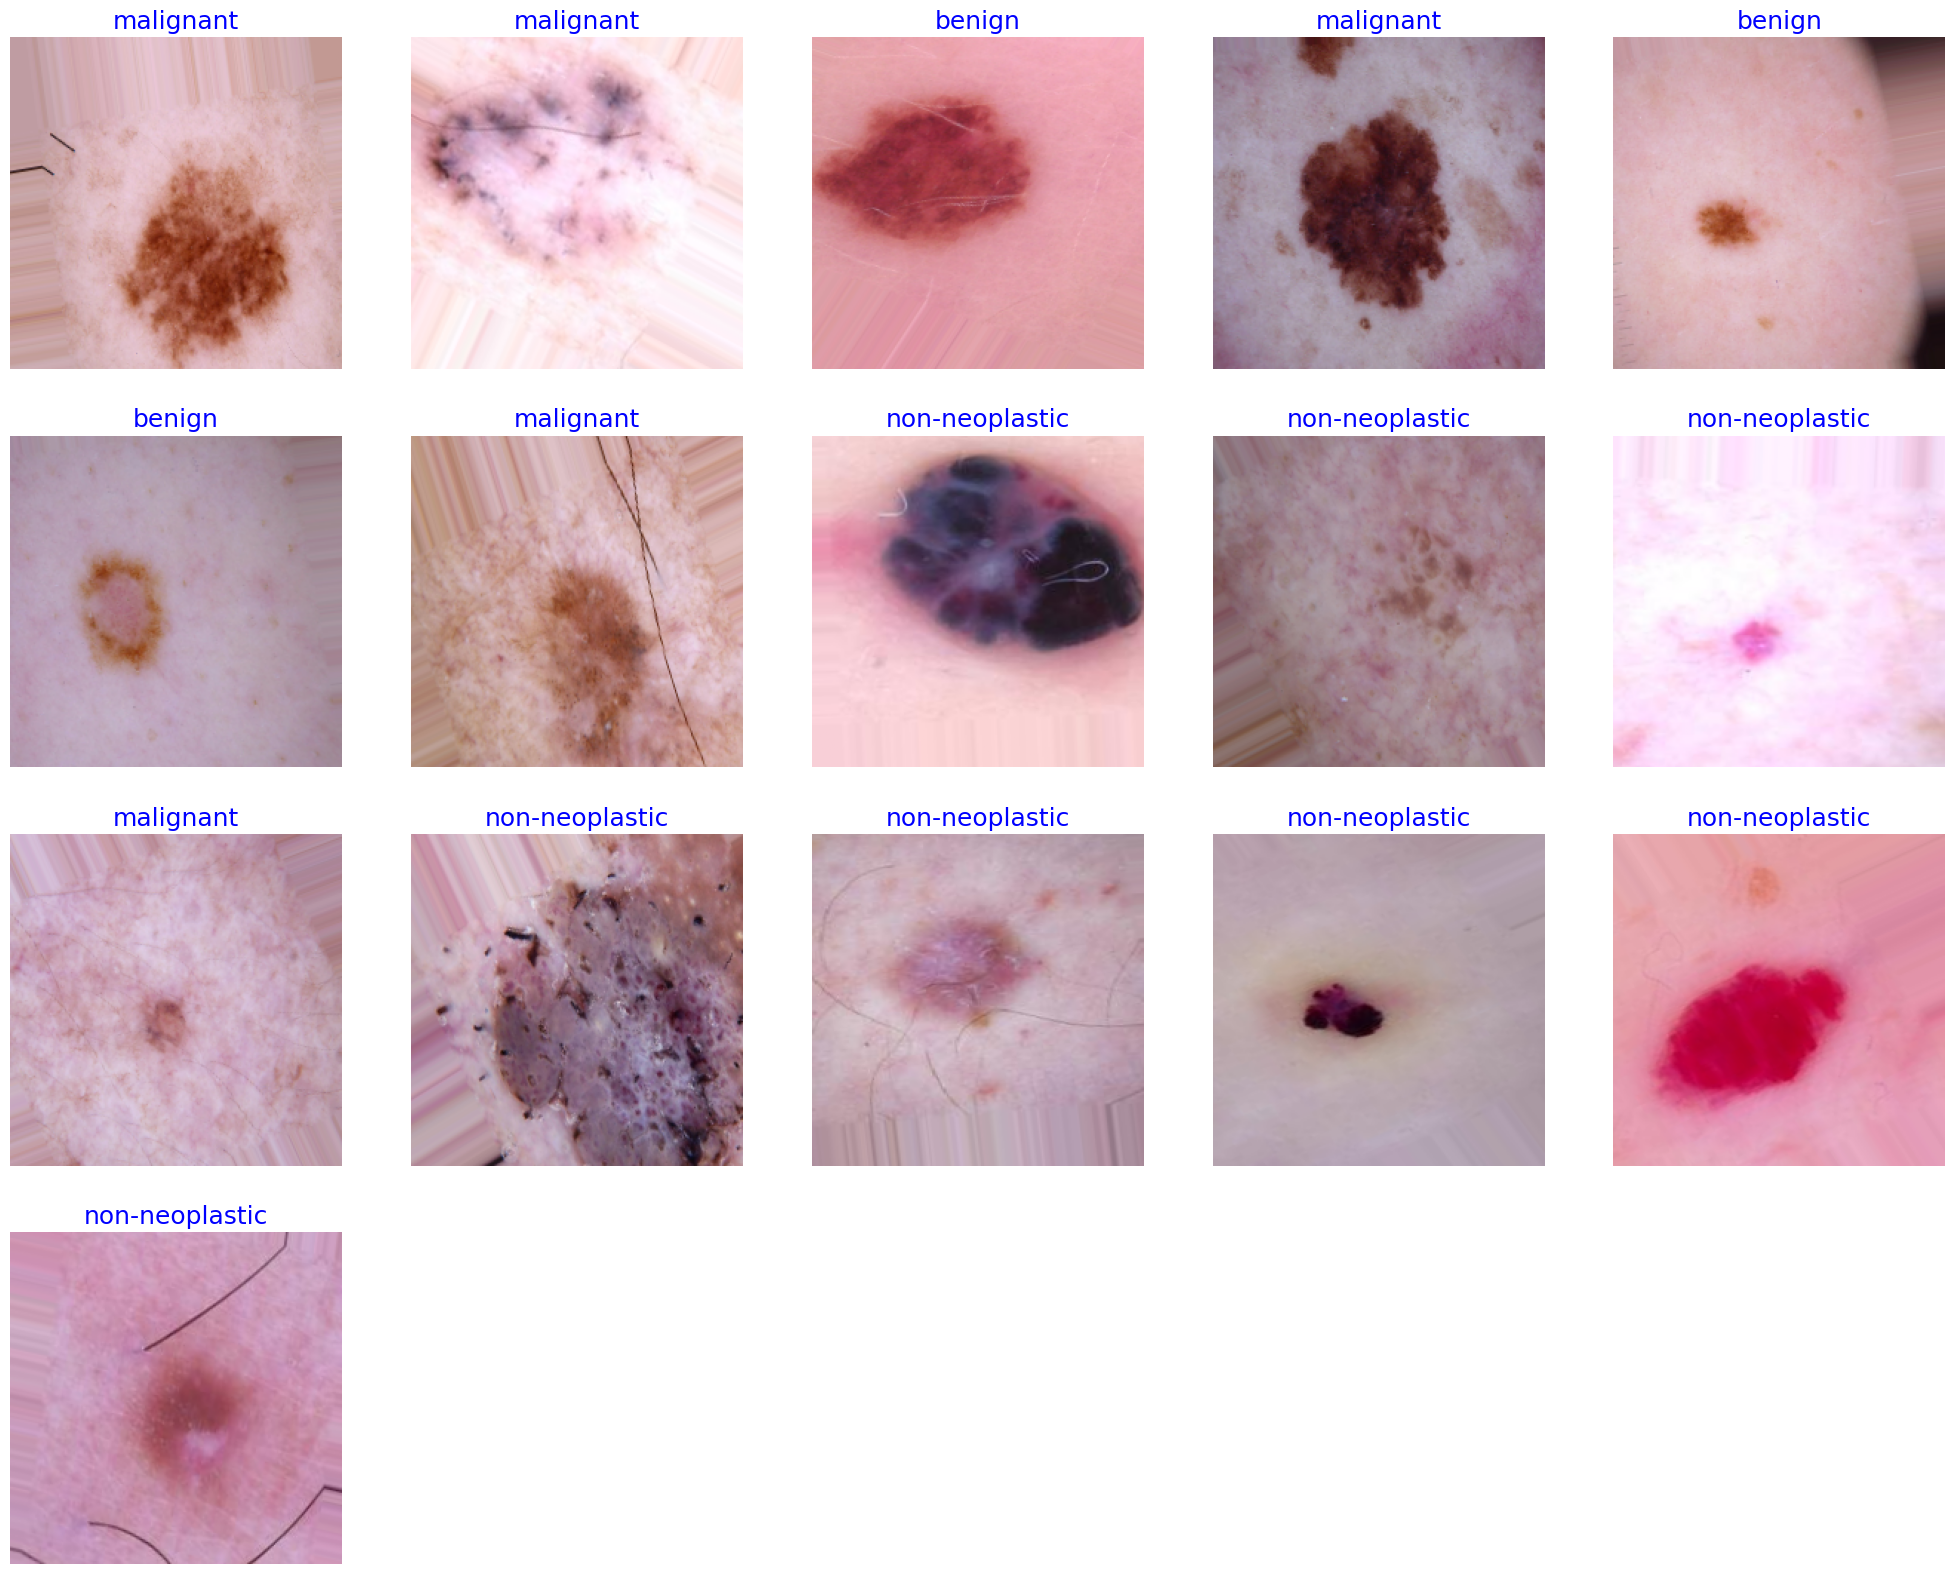

In [22]:
show_image_samples(train_data_generator)

## ResNet50


#### F1 score metric function for model compilation

In [23]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### focal loss function for model compilation (not yet in use)

In [24]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

#### Model architecture

In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import math

# Create a base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # use the pretrained weights of the imagenet dataset, include_top=False means that we do not want to include the last layer of the model
num_classes = len(train_data_generator.class_indices) 

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for classification
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x) 
#x = Conv2D(64, (3, 3), activation='relu')(x) --> this made things worse... could still be interesting to add a conv block here though...
#x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
#x = Dense(1024, activation='relu')(x) # fully connected layer with 1024 neurons and ReLU activation, relu is used to introduce non-linearity
x= Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x, name='Resnet50_tertiary_augmentation_in_train_data_generator')

# Compile the model with a custom optimizer (SGD with momentum)
custom_optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy',f1_score, Recall()])

# Print model summary
model.summary()

Model: "Resnet50_tertiary_augmentation_in_train_data_generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                         

### Callback functions

#### Learning rate scheduler for model compilation

In [26]:
#defining a learning rate scheduler
import math
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.001  # Initial learning rate
    target_lr = 0.0001  # Target learning rate for warmup
    warmup_epochs = 10  # Number of epochs for warmup
    drop = 0.8  # Learning rate drop factor
    epochs_drop = 4  # Number of epochs after which learning rate will drop

    #During the first 10 epochs, the learning rate will gradually increase from a very low value to the target warmup value (target_lr). 
    #After the warmup phase, the original learning rate schedule takes over.

    # Warmup phase
    if epoch < warmup_epochs: 
        return initial_lr + (target_lr - initial_lr) * epoch / warmup_epochs
    # After warmup, use the original schedule
    else:
        return initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))


# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

#### Class weights 

In [27]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.335111111111111, 1: 0.7776791000592066, 2: 0.7776791000592066}

#### Reducing LR On Plateau

If the validation loss plateaus, the learning rate will be reduced.

In [28]:
# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
    )

#### Early stopping

If the model's validation accuracy doesn't improve for 5 epochs, training will halt and revert to the best weights.

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor for early stopping
    patience=5,         # Number of epochs with no improvement to wait before stopping
    verbose=1,          # Whether to log the stopping condition or not
    restore_best_weights=True  # Restore the model weights to the best epoch
    # set range in loss function
)

## Model Training

## Content from Notebook 1

# Train the model
history = model.fit(
    train_data_generator,  # Training data generator
    epochs=NUM_EPOCHS,  # Number of training epochs
    verbose=1,  # Verbosity level during training (0, 1, or 2)
    batch_size=BATCH_SIZE,  # Batch size for training
    callbacks=[lr_scheduler],  # Updated callbacks list
    validation_split=0.0,  # Fraction of the training data to use as validation data (0.0 means no split)
    validation_data=validation_generator,  # Validation data generator
    shuffle=True,  # Shuffle the training data before each epoch
    sample_weight=None,  # Optional sample weights for training data
    class_weight=class_weights,  # Optional class weights for loss calculation
    initial_epoch=0,  # Initial training epoch (useful for resuming training)
    steps_per_epoch=None,  # Number of steps per epoch (default is len(x_train) // batch_size)
    validation_steps=None,  # Number of steps for validation (default is len(x_val) // batch_size)
    validation_batch_size=None,  # Batch size for validation (default is batch_size)
    validation_freq=1,  # Frequency to validate the model on the validation set
    max_queue_size=10,  # Maximum size of the generator queue
    workers=-1,  # Maximum number of processes to generate data in parallel (-1 means all CPUs)
    use_multiprocessing=False  # Use multiprocessing for data generation (True or False)
)

---

## Content from Notebook 2

# Train the model
history = model.fit(
    train_data_generator,       # Training data generator
    epochs=NUM_EPOCHS,          # Number of training epochs
    verbose=1,                  # Verbosity level during training (0, 1, or 2)
    batch_size=BATCH_SIZE,      # Batch size for training
    callbacks=[
        lr_scheduler, 
        early_stopping,
        best_weights_checkpoint],
    validation_split=0.0,       # Fraction of the training data to use as validation data (0.0 means no split)
    validation_data=validation_generator,  # Validation data generator
    shuffle=True,               # Shuffle the training data before each epoch
    sample_weight=None,         # Optional sample weights for training data
    class_weight=class_weights,  # Optional class weights for loss calculation
    initial_epoch=0,            # Initial training epoch (useful for resuming training)
    steps_per_epoch=None,       # Number of steps per epoch (default is len(x_train) // batch_size)
    validation_steps=None,      # Number of steps for validation (default is len(x_val) // batch_size)
    validation_batch_size=None,  # Batch size for validation (default is batch_size)
    validation_freq=1,          # Frequency to validate the model on the validation set
    max_queue_size=10,          # Maximum size of the generator queue
    workers=-1,                 # Maximum number of processes to generate data in parallel (-1 means all CPUs)
    use_multiprocessing=False   # Use multiprocessing for data generation (True or False)
)

## Plotting accuracy, f1 score, recall and loss of train and validation set

#### Plotting Accuracy  of train and validation set

## Content from Notebook 1

# plotting accuracy of train and validation
import matplotlib.pyplot as plt
mh.model_plot_accuracy(history)
plt.ylim(0,1)

---

## Content from Notebook 2

# plotting accuracy of train and validation
mh.model_plot_accuracy(history)
plt.ylim(0,1)

#### F1 Score of train and validation set

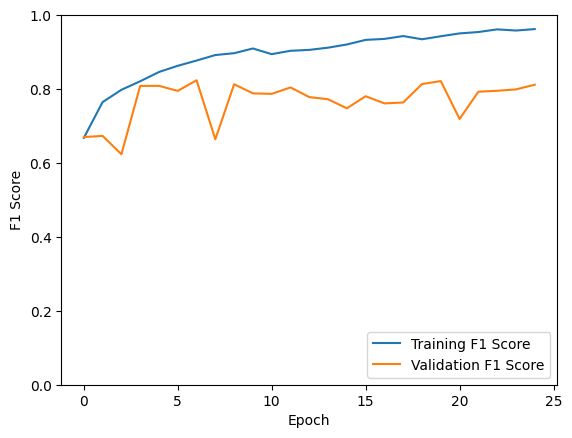

In [32]:
import matplotlib.pyplot as plt

# Assuming you have a variable named 'history' containing the training history
# (e.g., history = model.fit(...) where model is your Keras model)
# You can access the loss values from 'history.history'

# Plot the loss functions
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])  # Set the y-axis limits as needed
plt.legend(loc='lower right')  # You can adjust the legend position
plt.show()  # Show the plot

#### Recall of train and validation set

In [33]:
'''import matplotlib.pyplot as plt

# Plot the recall
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0, 1])  
plt.legend(loc='lower right')  # adjust the legend position
plt.show()  # Show the plot'''

"import matplotlib.pyplot as plt\n\n# Plot the recall\nplt.plot(history.history['recall'], label='Training Recall')\nplt.plot(history.history['val_recall'], label='Validation Recall')\nplt.xlabel('Epoch')\nplt.ylabel('Recall')\nplt.ylim([0, 1])  \nplt.legend(loc='lower right')  # adjust the legend position\nplt.show()  # Show the plot"

#### Plotting Loss of train and validation set

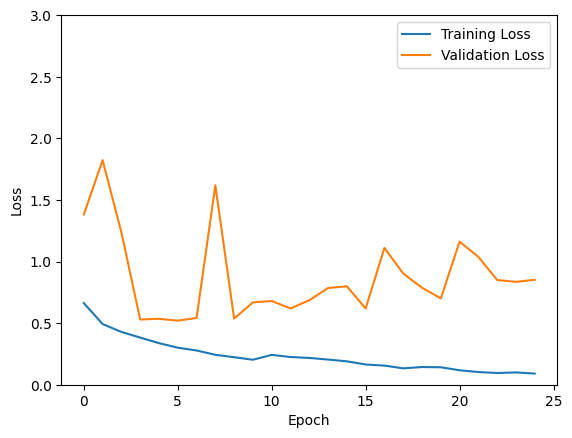

In [34]:
import matplotlib.pyplot as plt

# Plot the loss functions
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])  # Set the y-axis limits as needed
plt.legend(loc='upper right')  # You can adjust the legend position
plt.show()  # Show the plot


## Evaluating the model on the test set

 > Evaluating model Resnet50_tertiary_augmentation_in_train_data_generator:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 37s 1s/step
 > Model predictions obtained.
 > Macro AUC: 0.933463201463332
 > Micro AUC: 0.9422758773869426


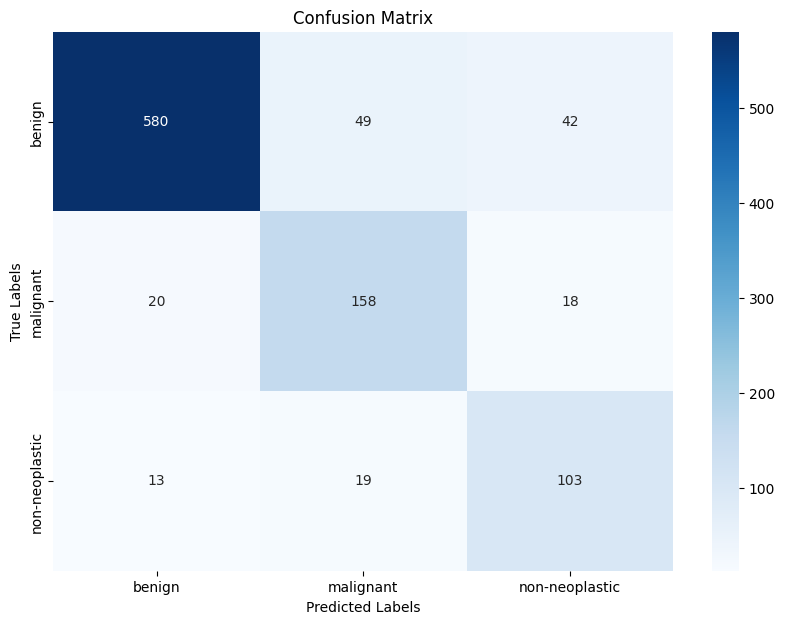



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       671
           1       0.70      0.81      0.75       196
           2       0.63      0.76      0.69       135

    accuracy                           0.84      1002
   macro avg       0.76      0.81      0.78      1002
weighted avg       0.86      0.84      0.84      1002

 > Evaluating model on test set...
32/32 [==============================] - 37s 1s/step - loss: 0.8490 - accuracy: 0.8393 - f1_score: 0.8291 - recall_1: 0.8363
loss: 0.8490322828292847
accuracy: 0.8393213748931885
f1_score: 0.8290795683860779
recall_1: 0.8363273739814758
 > Done.


([{'loss': 0.8490322828292847},
  {'accuracy': 0.8393213748931885},
  {'f1_score': 0.8290795683860779},
  {'recall_1': 0.8363273739814758}],
 array([[580,  49,  42],
        [ 20, 158,  18],
        [ 13,  19, 103]]),
 (0.9422758773869426, 0.933463201463332))

In [35]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [36]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/eigenaarti/Documents/Data_Science/neue_fische/Repositories/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Pretrained ResNet50 CNN:

* Tests have shown that adding a dropout layer to the architecture, batch size of 16 as well as regularization increased the models performance. This is included in this model as well as setting model checkpoints.
* Thoughts on model checkpoints:
  * model.evaluate() in Keras uses the weights of the model at the time the method is called. So if you train a model for 20 epochs and call model.evaluate() immediately after training without making any further changes to the weights, then it will use the weights from the last, 20th epoch.
  * However, if you use a ModelCheckpoint with save_best_only=True during training, then the model's weights will only be saved if a particular metric (such as validation accuracy) improves. If you load these best weights into your model after training and then call model.evaluate(), the weights of the epoch with the best results will be used.
  * In summary, model.evaluate() always uses the current weights of the model. It is up to you to determine which weights are loaded in the model at which point in time. This is why we should use ModelCheckpoint with save_best_only=True to evaluate the *best* model.
* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images
* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import math

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam as Adam_legacy
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.utils import class_weight


sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 226
NUM_EPOCHS = 20

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"
FILEPATH_MODELS = "../models/"

MODEL_NAME = 'Resnet50_tertiary_new_setup' # please adapt according to your changes using _ and - instead of " "

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 16 # Adapted according to findings

## ResNet50 Setup


### Model architecture

In [ ]:
# Create a base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # use the pretrained weights of the imagenet dataset, include_top=False means that we do not want to include the last layer of the model
num_classes = len(train_data_generator.class_indices) 

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for classification
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu',
           kernel_regularizer=l2(0.1)
           )(x)
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
  
x = Dense(128, activation='relu', kernel_regularizer=l2(0.1))(x)    

x = Dropout(0.5)(x)                                                 

x= Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.1))(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x, name=MODEL_NAME)

model.compile(
    optimizer=Adam_legacy(learning_rate=0.001), 
    loss='categorical_crossentropy',
    metrics=['accuracy', mh.f1_score])

# Print model summary
#model.summary()

In [ ]:
# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.0001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop

    # Calculate the learning rate for the current epoch
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor for early stopping
    patience=8,         # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore the model weights to the best epoch
    # set range in loss function
)

#### Model checkpoint

In [ ]:
timestamp = datetime.now()

best_weights_checkpoint = ModelCheckpoint(
    filepath = f'{FILEPATH_MODELS}model_best-epoch_{timestamp}.h5', 
    save_best_only=True, 
    save_weights_only=False,
    monitor='val_accuracy', 
    mode='max', 
    verbose=1
)

### Class weights 

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

In [ ]:
# Train the model
history = model.fit(
    train_data_generator,       # Training data generator
    epochs=NUM_EPOCHS,          # Number of training epochs
    verbose=1,                  # Verbosity level during training (0, 1, or 2)
    batch_size=BATCH_SIZE,      # Batch size for training
    callbacks=[
        lr_scheduler, 
        early_stopping,
        best_weights_checkpoint],
    validation_split=0.0,       # Fraction of the training data to use as validation data (0.0 means no split)
    validation_data=validation_generator,  # Validation data generator
    shuffle=True,               # Shuffle the training data before each epoch
    sample_weight=None,         # Optional sample weights for training data
    class_weight=class_weights,  # Optional class weights for loss calculation
    initial_epoch=0,            # Initial training epoch (useful for resuming training)
    steps_per_epoch=None,       # Number of steps per epoch (default is len(x_train) // batch_size)
    validation_steps=None,      # Number of steps for validation (default is len(x_val) // batch_size)
    validation_batch_size=None,  # Batch size for validation (default is batch_size)
    validation_freq=1,          # Frequency to validate the model on the validation set
    max_queue_size=10,          # Maximum size of the generator queue
    workers=-1,                 # Maximum number of processes to generate data in parallel (-1 means all CPUs)
    use_multiprocessing=False   # Use multiprocessing for data generation (True or False)
)

## Plotting accuracy and loss of train and validation set

In [ ]:
# plotting accuracy of train and validation
mh.model_plot_accuracy(history)
plt.ylim(0,1)

In [ ]:
# Assuming you have a variable named 'history' containing the training history
# (e.g., history = model.fit(...) where model is your Keras model)
# You can access the loss values from 'history.history'

# Plot the loss functions
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])  # Set the y-axis limits as needed
plt.legend(loc='lower right')  # You can adjust the legend position
plt.show()  # Show the plot

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])  # Set the y-axis limits as needed
plt.legend(loc='upper right')  # You can adjust the legend position
plt.show()  # Show the plot


In [ ]:
timestamp = datetime.now()
model_path = f"{FILEPATH_MODELS}model_last-epoch_{timestamp}.h5"
model.save(model_path)

## Optional: Continue training 

In [ ]:
# Continue training for another 10 epochs
additional_epochs = 10
continue_training = False

if continue_training:
    history_continued = model.fit(
        train_data_generator,
        steps_per_epoch=None,
        epochs=NUM_EPOCHS + additional_epochs,
        initial_epoch=NUM_EPOCHS,  # start from the epoch after your last training session
        validation_data=validation_generator)


In [ ]:
if continue_training:
    mh.model_plot_accuracy(history_continued)

In [ ]:
if continue_training:
    mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

In [ ]:
if continue_training:
    timestamp = datetime.now()
    model_path = f"../models/model_last-epoch_{timestamp}.h5.h5"
    model.save(model_path)